You may need to install OpenCV by "!pip install opencv-contrib-python".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import cv2
import glob
import h5py
from skimage.morphology import disk
from scipy.stats import pearsonr
from scipy.stats import skew
from scipy.ndimage import gaussian_filter

from contrast import *

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
# for plot figures
plt.rcParams['svg.fonttype'] = 'none'
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

## Load data

In [3]:
movie_name1 = "../data/image_crops_upper_bgr.h5"
movie_name2 = "../data/image_crops_lower_bgr.h5"

all_images_upper=read_movie_from_h5(movie_name1) #upper visual field
print (all_images_upper.shape)
all_images_lower=read_movie_from_h5(movie_name2) #lower visual field
print (all_images_lower.shape)

(1500, 128, 128, 3)
(1500, 128, 128, 3)


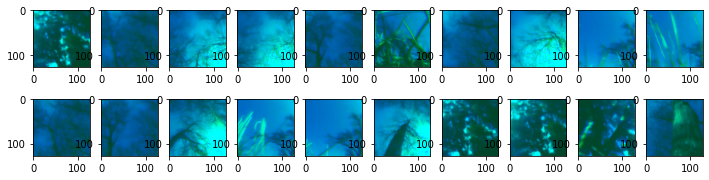

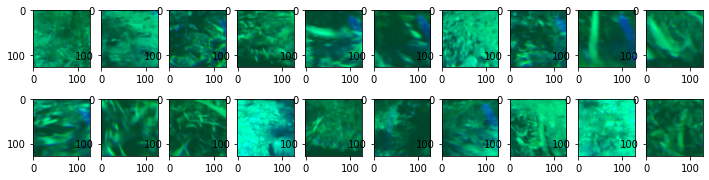

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=10,figsize=(12,3))
for ii in range(2):
    for jj in range(10):
        axes[ii,jj].imshow(img_real2view(all_images_upper[ii*500+jj*50,:,:,::-1]),vmin=0,vmax=255)
#
fig, axes = plt.subplots(nrows=2, ncols=10,figsize=(12,3))
for ii in range(2):
    for jj in range(10):
        axes[ii,jj].imshow(img_real2view(all_images_lower[ii*500+jj*50,:,:,::-1]),vmin=0,vmax=255)

## Preprocessing: discard image crops and separate to 3 groups

[0.06693223 0.17433651 0.30660464 0.62974327]
500
500
500


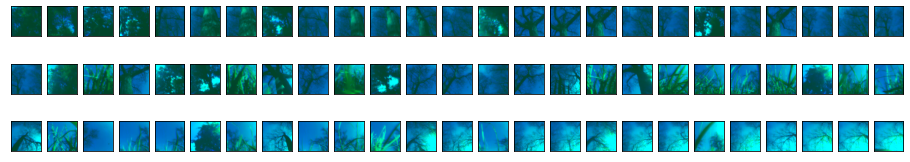

In [5]:
#upper
#separate image crops to 3 groups using quantile of UVG_mean
imagecrops=np.copy(all_images_upper)
quantiles=[0,1/3,2/3,1]
UVG_mean=np.mean(imagecrops[:,:,:,:2]/255,axis=(1,2,3))
tempind=np.argsort(UVG_mean)
temp=imagecrops[tempind]
imagecrops=np.copy(temp) 
UVG_mean=np.mean(imagecrops[:,:,:,:2]/255,axis=(1,2,3))
quantile_results=np.quantile(UVG_mean,quantiles)
print (quantile_results)
upper_groups=[]
for ii in range(len(quantiles)-1):
    if ii==0:
        tempind=np.where((UVG_mean>=quantile_results[ii])&(UVG_mean<=quantile_results[ii+1]))[0]
    else:
        tempind=np.where((UVG_mean>quantile_results[ii])&(UVG_mean<=quantile_results[ii+1]))[0]
    upper_groups.append(imagecrops[tempind])
    print (len(upper_groups[ii]))
#plot
num=25
nrows=len(upper_groups)
fig,axes=plt.subplots(nrows=nrows,ncols=num,figsize=(int(num/1.5),nrows))
for ii in range(nrows):
    for jj in range(num):
        temp=upper_groups[ii]
        delta=int(len(temp)/num)
        axes[ii,jj].imshow(img_real2view(temp[jj*delta,:,:,::-1]))
        axes[ii,jj].set_xticks([])
        axes[ii,jj].set_yticks([])

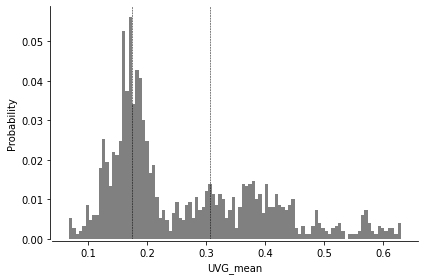

In [6]:
#plot histogram of UVG_mean
hist_max=np.max(UVG_mean) 
hist_min=np.min(UVG_mean) 
weights = np.ones_like(UVG_mean)/float(len(UVG_mean))
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6,4))
axes.hist(UVG_mean, bins=100,color='gray',range=[hist_min,hist_max],\
               weights=weights,alpha=1)
for ii in range(len(quantile_results)-2):
    axes.axvline(x=quantile_results[ii+1],color='k', linestyle='--',linewidth=0.5)
axes.set_xlabel('UVG_mean')
axes.set_ylabel('Probability')
adjust_spines(axes, ['left', 'bottom'])
plt.tight_layout()

[0.05409821 0.12050466 0.18787786 0.68553132]
500
500
500


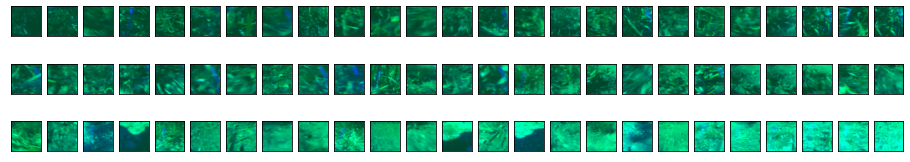

In [7]:
#lower
#separate image crops to 3 groups using quantile of UVG_mean
imagecrops=np.copy(all_images_lower)
quantiles=[0,1/3,2/3,1]
UVG_mean=np.mean(imagecrops[:,:,:,:2]/255,axis=(1,2,3))
tempind=np.argsort(UVG_mean)
temp=imagecrops[tempind]
imagecrops=np.copy(temp) 
UVG_mean=np.mean(imagecrops[:,:,:,:2]/255,axis=(1,2,3))
quantile_results=np.quantile(UVG_mean,quantiles)
print (quantile_results)
lower_groups=[]
for ii in range(len(quantiles)-1):
    if ii==0:
        tempind=np.where((UVG_mean>=quantile_results[ii])&(UVG_mean<=quantile_results[ii+1]))[0]
    else:
        tempind=np.where((UVG_mean>quantile_results[ii])&(UVG_mean<=quantile_results[ii+1]))[0]
    lower_groups.append(imagecrops[tempind])
    print (len(lower_groups[ii]))
#plot
num=25
nrows=len(lower_groups)
fig,axes=plt.subplots(nrows=nrows,ncols=num,figsize=(int(num/1.5),nrows))
for ii in range(nrows):
    for jj in range(num):
        temp=lower_groups[ii]
        delta=int(len(temp)/num)
        axes[ii,jj].imshow(img_real2view(temp[jj*delta,:,:,::-1]))
        axes[ii,jj].set_xticks([])
        axes[ii,jj].set_yticks([])

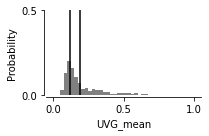

In [8]:
#plot histogram of UVG_mean
hist_max=1 
hist_min=0 
weights = np.ones_like(UVG_mean)/float(len(UVG_mean))
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(3,2))
axes.hist(UVG_mean, bins=40,color='gray',range=[hist_min,hist_max],\
               weights=weights,alpha=1)
for ii in range(len(quantile_results)-2):
    axes.axvline(x=quantile_results[ii+1],color='k')
axes.set_xticks([0,0.5,1])
axes.set_yticks([0,0.5])
axes.set_xlabel('UVG_mean')
axes.set_ylabel('Probability')
adjust_spines(axes, ['left', 'bottom'])
plt.tight_layout()

## Contrast

### group2

In [10]:
#pick the data from groups
ind_group=2
upper_imgs=upper_groups[ind_group]
lower_imgs=lower_groups[ind_group]

centersigmas=np.array([2,6,10,14])
RFradius=np.array([2,7,12,16])
onoff_num=len(upper_imgs)*10 
#upper visual field, UV channel
upper_UV_RF_onoffs=np.zeros((4,onoff_num))
upper_UV_RF_rms2s=np.zeros((4,onoff_num))
for ii in range(4):
    upper_UV_RF_onoffs[ii],upper_UV_RF_rms2s[ii]=onoff_rms2_random_imgs(1001,onoff_num,\
                                                 centersigmas[ii],RFradius[ii],upper_imgs[...,0]/255.0)
    
#upper visual field, G channel
upper_G_RF_onoffs=np.zeros((4,onoff_num))
upper_G_RF_rms2s=np.zeros((4,onoff_num))
for ii in range(4):
    upper_G_RF_onoffs[ii],upper_G_RF_rms2s[ii]=onoff_rms2_random_imgs(1001,onoff_num,\
                                                 centersigmas[ii],RFradius[ii],upper_imgs[...,1]/255.0)

onoff_num=len(lower_imgs)*10 
#lower visual field, UV channel
lower_UV_RF_onoffs=np.zeros((4,onoff_num))
lower_UV_RF_rms2s=np.zeros((4,onoff_num))
for ii in range(4):
    lower_UV_RF_onoffs[ii],lower_UV_RF_rms2s[ii]=onoff_rms2_random_imgs(3001,onoff_num,\
                                                 centersigmas[ii],RFradius[ii],lower_imgs[...,0]/255.0)

#lower visual field, G channel
lower_G_RF_onoffs=np.zeros((4,onoff_num))
lower_G_RF_rms2s=np.zeros((4,onoff_num))
for ii in range(4):
    lower_G_RF_onoffs[ii],lower_G_RF_rms2s[ii]=onoff_rms2_random_imgs(3001,onoff_num,\
                                                 centersigmas[ii],RFradius[ii],lower_imgs[...,1]/255.0)
#
print (upper_UV_RF_onoffs.shape)
print (lower_UV_RF_onoffs.shape)

(4, 5000)
(4, 5000)


#### ONOFF

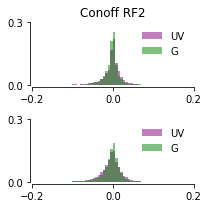

In [11]:
#show Conoff RF2 distribution
onoff_upper_UV=np.copy(upper_UV_RF_onoffs[0])
onoff_upper_G =np.copy(upper_G_RF_onoffs[0])
onoff_lower_UV=np.copy(lower_UV_RF_onoffs[0])
onoff_lower_G =np.copy(lower_G_RF_onoffs[0])
onoff_max=0.2 
onoff_min=-0.2 
log_flag=False #log scale histogram if it is True
weights = np.ones_like(onoff_upper_UV)/float(len(onoff_upper_UV))
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(3,3))

axes[0].hist(onoff_upper_UV, bins=64,color='purple',range=[onoff_min,onoff_max],\
               weights=weights,log=log_flag,alpha=0.5,label='UV')
axes[0].hist(onoff_upper_G, bins=64,color='green',range=[onoff_min,onoff_max],\
               weights=weights,log=log_flag,alpha=0.5,label='G')
axes[0].set_xlim([-0.2,0.2])
axes[0].set_xticks([-0.2,0,0.2])
axes[0].set_yticks([0,0.3])
axes[0].set_title('Conoff RF2')
axes[0].legend(loc='best',frameon=False)
adjust_spines(axes[0], ['left', 'bottom'])
#
weights = np.ones_like(onoff_lower_UV)/float(len(onoff_lower_UV))
axes[1].hist(onoff_lower_UV, bins=64,color='purple',range=[onoff_min,onoff_max],\
               weights=weights,log=log_flag,alpha=0.5,label='UV')
axes[1].hist(onoff_lower_G, bins=64,color='green',range=[onoff_min,onoff_max],\
               weights=weights,log=log_flag,alpha=0.5,label='G')
axes[1].set_xlim([-0.2,0.2])
axes[1].set_xticks([-0.2,0,0.2])
axes[1].set_yticks([0,0.3])
axes[1].legend(loc='best',frameon=False)
adjust_spines(axes[1], ['left', 'bottom'])
plt.tight_layout()

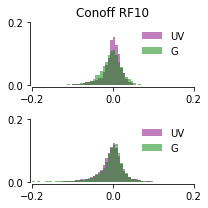

In [12]:
#show Conoff RF10 distribution
onoff_upper_UV=np.copy(upper_UV_RF_onoffs[2])
onoff_upper_G =np.copy(upper_G_RF_onoffs[2])
onoff_lower_UV=np.copy(lower_UV_RF_onoffs[2])
onoff_lower_G =np.copy(lower_G_RF_onoffs[2])
onoff_max=0.2 
onoff_min=-0.2 
log_flag=False #log scale histogram if it is True
weights = np.ones_like(onoff_upper_UV)/float(len(onoff_upper_UV))
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(3,3))
axes[0].hist(onoff_upper_UV, bins=64,color='purple',range=[onoff_min,onoff_max],\
               weights=weights,log=log_flag,alpha=0.5,label='UV')
axes[0].hist(onoff_upper_G, bins=64,color='green',range=[onoff_min,onoff_max],\
               weights=weights,log=log_flag,alpha=0.5,label='G')
axes[0].set_xlim([-0.2,0.2])
axes[0].set_xticks([-0.2,0,0.2])
axes[0].set_yticks([0,0.2])
axes[0].set_title('Conoff RF10')
axes[0].legend(loc='best',frameon=False)
adjust_spines(axes[0], ['left', 'bottom'])
#
weights = np.ones_like(onoff_lower_UV)/float(len(onoff_lower_UV))
axes[1].hist(onoff_lower_UV, bins=64,color='purple',range=[onoff_min,onoff_max],\
               weights=weights,log=log_flag,alpha=0.5,label='UV')
axes[1].hist(onoff_lower_G, bins=64,color='green',range=[onoff_min,onoff_max],\
               weights=weights,log=log_flag,alpha=0.5,label='G')
axes[1].set_xlim([-0.2,0.2])
axes[1].set_xticks([-0.2,0,0.2])
axes[1].set_yticks([0,0.2])
axes[1].legend(loc='best',frameon=False)
adjust_spines(axes[1], ['left', 'bottom'])
plt.tight_layout()

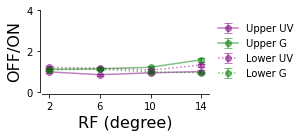

In [13]:
#calculate off/on ratio, 
upper_UV_RF_offratios=np.zeros(4)
upper_UV_RF_offratiolowqs=np.zeros(4) #lower_quartile
upper_UV_RF_offratiohigqs=np.zeros(4) #upper_quartile
for ii in range(4):
    temp=upper_UV_RF_onoffs[ii]
    tempmax=0 
    upper_UV_RF_offratios[ii]=len(temp[np.where(temp<-0.02*tempmax)])/len(temp[np.where(temp>0.02*tempmax)])
    low_perc,high_perc=bootstrap('offratios',temp,num_exp=10000,seed=66)
    upper_UV_RF_offratiolowqs[ii]  = upper_UV_RF_offratios[ii]-low_perc
    upper_UV_RF_offratiohigqs[ii]  =-upper_UV_RF_offratios[ii]+high_perc 
#upper visual field, G channel
upper_G_RF_offratios=np.zeros(4)
upper_G_RF_offratiolowqs=np.zeros(4) #lower_quartile
upper_G_RF_offratiohigqs=np.zeros(4) #upper_quartile
for ii in range(4):
    temp=upper_G_RF_onoffs[ii]
    tempmax=0 
    upper_G_RF_offratios[ii]=len(temp[np.where(temp<-0.02*tempmax)])/len(temp[np.where(temp>0.02*tempmax)])
    low_perc,high_perc=bootstrap('offratios',temp,num_exp=10000,seed=66)
    upper_G_RF_offratiolowqs[ii]  = upper_G_RF_offratios[ii]-low_perc
    upper_G_RF_offratiohigqs[ii]  =-upper_G_RF_offratios[ii]+high_perc 
#lower visual field, UV channel
lower_UV_RF_offratios=np.zeros(4)
lower_UV_RF_offratiolowqs=np.zeros(4) #lower_quartile
lower_UV_RF_offratiohigqs=np.zeros(4) #upper_quartile
for ii in range(4):
    temp=lower_UV_RF_onoffs[ii]
    tempmax=0 
    lower_UV_RF_offratios[ii]=len(temp[np.where(temp<-0.02*tempmax)])/len(temp[np.where(temp>0.02*tempmax)])  
    low_perc,high_perc=bootstrap('offratios',temp,num_exp=10000,seed=88)
    lower_UV_RF_offratiolowqs[ii]  = lower_UV_RF_offratios[ii]-low_perc
    lower_UV_RF_offratiohigqs[ii]  =-lower_UV_RF_offratios[ii]+high_perc 
#lower visual field, G channel
lower_G_RF_offratios=np.zeros(4)
lower_G_RF_offratiolowqs=np.zeros(4) #lower_quartile
lower_G_RF_offratiohigqs=np.zeros(4) #upper_quartile
for ii in range(4):
    temp=lower_G_RF_onoffs[ii]
    tempmax=0 
    lower_G_RF_offratios[ii]=len(temp[np.where(temp<-0.02*tempmax)])/len(temp[np.where(temp>0.02*tempmax)])
    low_perc,high_perc=bootstrap('offratios',temp,num_exp=10000,seed=88)
    lower_G_RF_offratiolowqs[ii]  = lower_G_RF_offratios[ii]-low_perc
    lower_G_RF_offratiohigqs[ii]  =-lower_G_RF_offratios[ii]+high_perc 
#plot
RFs=np.array([2,6,10,14])
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,1.5))
ax.errorbar(RFs,upper_UV_RF_offratios,yerr=(upper_UV_RF_offratiolowqs,upper_UV_RF_offratiohigqs),marker='o',\
            color='purple',linestyle='-', label='Upper UV',alpha=0.5, capsize=4)
ax.errorbar(RFs,upper_G_RF_offratios, yerr=(upper_G_RF_offratiolowqs, upper_G_RF_offratiohigqs), marker='o',\
            color='g',     linestyle='-', label='Upper G',alpha=0.5, capsize=4)
ax.errorbar(RFs,lower_UV_RF_offratios,yerr=(lower_UV_RF_offratiolowqs,lower_UV_RF_offratiohigqs),marker='o',\
            color='purple',linestyle=':', label='Lower UV',alpha=0.5, capsize=4)
ax.errorbar(RFs,lower_G_RF_offratios, yerr=(lower_G_RF_offratiolowqs, lower_G_RF_offratiohigqs), marker='o',\
            color='g',linestyle=':',      label='Lower G', alpha=0.5, capsize=4)

ax.legend(loc='best',fontsize=16)
ax.set_xticks([2,6,10,14])
ax.set_yticks([0,2,4])
ax.set_xlabel('RF (degree)', fontsize=16)
ax.set_ylabel('OFF/ON', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))

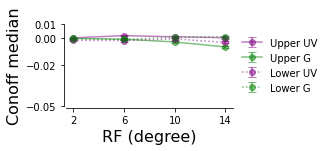

In [14]:
#calculate onoffmedians
RFradius=np.array([2,7,12,16])
#upper visual field, UV channel
upper_UV_RF_onoffmedians=np.zeros(4)
upper_UV_RF_onoffstds=np.zeros(4)
upper_UV_RF_onofflowqs=np.zeros(4) #lower_quartile
upper_UV_RF_onoffhigqs=np.zeros(4) #upper_quartile
for ii in range(4):
    upper_UV_RF_onoffmedians[ii]=np.median(upper_UV_RF_onoffs[ii])
    low_perc,high_perc=bootstrap('median',upper_UV_RF_onoffs[ii],num_exp=10000,seed=66)
    upper_UV_RF_onofflowqs[ii]  = upper_UV_RF_onoffmedians[ii]-low_perc
    upper_UV_RF_onoffhigqs[ii]  =-upper_UV_RF_onoffmedians[ii]+high_perc       
#upper visual field, G channel
upper_G_RF_onoffmedians=np.zeros(4)
upper_G_RF_onoffstds=np.zeros(4)
upper_G_RF_onofflowqs=np.zeros(4) #lower_quartile
upper_G_RF_onoffhigqs=np.zeros(4) #upper_quartile
for ii in range(4):
    upper_G_RF_onoffmedians[ii]=np.median(upper_G_RF_onoffs[ii])
    low_perc,high_perc=bootstrap('median',upper_G_RF_onoffs[ii],num_exp=10000,seed=66)
    upper_G_RF_onofflowqs[ii]  = upper_G_RF_onoffmedians[ii]-low_perc
    upper_G_RF_onoffhigqs[ii]  =-upper_G_RF_onoffmedians[ii]+high_perc    
#lower visual field, UV channel
lower_UV_RF_onoffmedians=np.zeros(4)
lower_UV_RF_onoffstds=np.zeros(4)
lower_UV_RF_onofflowqs=np.zeros(4) #lower_quartile
lower_UV_RF_onoffhigqs=np.zeros(4) #upper_quartile
for ii in range(4):
    lower_UV_RF_onoffmedians[ii]=np.median(lower_UV_RF_onoffs[ii])
    low_perc,high_perc=bootstrap('median',lower_UV_RF_onoffs[ii],num_exp=10000,seed=88)
    lower_UV_RF_onofflowqs[ii]  = lower_UV_RF_onoffmedians[ii]-low_perc
    lower_UV_RF_onoffhigqs[ii]  =-lower_UV_RF_onoffmedians[ii]+high_perc  
#lower visual field, G channel
lower_G_RF_onoffmedians=np.zeros(4)
lower_G_RF_onoffstds=np.zeros(4)
lower_G_RF_onofflowqs=np.zeros(4) #lower_quartile
lower_G_RF_onoffhigqs=np.zeros(4) #upper_quartile
for ii in range(4):
    lower_G_RF_onoffmedians[ii]=np.median(lower_G_RF_onoffs[ii])
    low_perc,high_perc=bootstrap('median',lower_G_RF_onoffs[ii],num_exp=10000,seed=88) 
    lower_G_RF_onofflowqs[ii]  = lower_G_RF_onoffmedians[ii]-low_perc
    lower_G_RF_onoffhigqs[ii]  =-lower_G_RF_onoffmedians[ii]+high_perc
#plot
RFs=np.array([2,6,10,14])
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,1.5))
ax.errorbar(RFs,upper_UV_RF_onoffmedians,yerr=(upper_UV_RF_onofflowqs,upper_UV_RF_onoffhigqs),marker='o',\
            color='purple',linestyle='-', label='Upper UV',alpha=0.5, capsize=4)
ax.errorbar(RFs,upper_G_RF_onoffmedians, yerr=(upper_G_RF_onofflowqs, upper_G_RF_onoffhigqs), marker='o',\
            color='g',     linestyle='-', label='Upper G',alpha=0.5, capsize=4)
ax.errorbar(RFs,lower_UV_RF_onoffmedians,yerr=(lower_UV_RF_onofflowqs,lower_UV_RF_onoffhigqs),marker='o',\
            color='purple',linestyle=':', label='Lower UV',alpha=0.5, capsize=4)
ax.errorbar(RFs,lower_G_RF_onoffmedians, yerr=(lower_G_RF_onofflowqs, lower_G_RF_onoffhigqs), marker='o',\
            color='g',linestyle=':',      label='Lower G', alpha=0.5, capsize=4)

ax.legend(loc='best',fontsize=16)
ax.set_xticks([2,6,10,14])
ax.set_yticks([-0.05,-0.02,0,0.01])
ax.set_xlabel('RF (degree)', fontsize=16)
ax.set_ylabel('Conoff median', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))

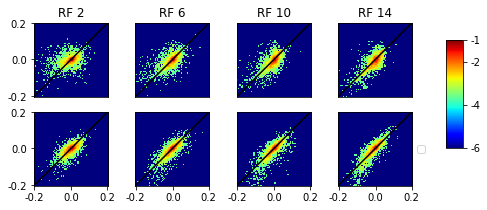

In [15]:
#Conoff relationship in two color channels, 2d histogram
xmax=0.2  
xmin=-0.2 
ymax=0.2  
ymin=-0.2 
if xmax>xmin*(-1.0):
    xmin=xmax*(-1.0)
else:
    xmax=xmin*(-1.0)
if ymax>ymin*(-1.0):
    ymin=ymax*(-1.0)
else:
    ymax=ymin*(-1.0)    
RFradius=np.array(['RF 2','RF 6','RF 10','RF 14'])

H_upper_RF_onoffs=np.zeros((4,64,64))
H_lower_RF_onoffs=np.zeros((4,64,64))
for ii in range(4):
    weights = np.ones_like(upper_UV_RF_onoffs[0])/float(len(upper_UV_RF_onoffs[0]))
    H_upper_RF_onoffs[ii],_,_=np.histogram2d(upper_UV_RF_onoffs[ii], \
                                   upper_G_RF_onoffs[ii], \
                                   bins=64,range=[[xmin,xmax],[ymin,ymax]],weights=weights)
    H_upper_RF_onoffs[ii]=np.log10(H_upper_RF_onoffs[ii]+1e-6)
    H_upper_RF_onoffs[ii]=H_upper_RF_onoffs[ii].T
    weights = np.ones_like(lower_UV_RF_onoffs[0])/float(len(lower_UV_RF_onoffs[0]))
    H_lower_RF_onoffs[ii],_,_=np.histogram2d(lower_UV_RF_onoffs[ii], \
                                   lower_G_RF_onoffs[ii], \
                                   bins=64,range=[[xmin,xmax],[ymin,ymax]],weights=weights)
    H_lower_RF_onoffs[ii]=np.log10(H_lower_RF_onoffs[ii]+1e-6)
    H_lower_RF_onoffs[ii]=H_lower_RF_onoffs[ii].T
#plot
H_max=-1 
H_min=-6 
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(8,3))
for ii in range(4):
    axes[0,ii].imshow(H_upper_RF_onoffs[ii], interpolation='nearest', origin='lower',cmap='jet',vmin=H_min, vmax=H_max)
    axes[0,ii].set_title(RFradius[ii])
    axes[0,ii].set_xticks([])
    axes[0,ii].set_yticks([])
    if ii==0:
        labels = [float("{0:.1f}".format(ymin)),'0.0',float("{0:.1f}".format(ymax))]
        axes[0,ii].set_yticks([0,32,63])
        axes[0,ii].set_yticklabels(labels)
    lims = [np.min([axes[0,ii].get_xlim(), axes[0,ii].get_ylim()]),  # min of both axes
            np.max([axes[0,ii].get_xlim(), axes[0,ii].get_ylim()]),  # max of both axes
           ]
    axes[0,ii].plot(lims, lims, 'k-')
for ii in range(4):
    im=axes[1,ii].imshow(H_lower_RF_onoffs[ii], interpolation='nearest', origin='lower',cmap='jet',vmin=H_min, vmax=H_max)
    axes[1,ii].set_yticks([])
    labels = [float("{0:.1f}".format(ymin)),'0.0',float("{0:.1f}".format(ymax))]
    axes[1,ii].set_xticks([0,32,63])
    axes[1,ii].set_xticklabels(labels)
    if ii==0:
        labels = [float("{0:.1f}".format(ymin)),'0.0',float("{0:.1f}".format(ymax))]
        axes[1,ii].set_yticks([0,32,63])
        axes[1,ii].set_yticklabels(labels)
    lims = [np.min([axes[1,ii].get_xlim(), axes[1,ii].get_ylim()]),  # min of both axes
            np.max([axes[1,ii].get_xlim(), axes[1,ii].get_ylim()]),  # max of both axes
           ]
    axes[1,ii].plot(lims, lims, 'k-')    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.5])
ticks=[-1,-2,-4,-6]
fig.colorbar(im, cax=cbar_ax,ticks=ticks,format="%d")
handles, labels = axes[1,3].get_legend_handles_labels()
lgd = axes[1,3].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

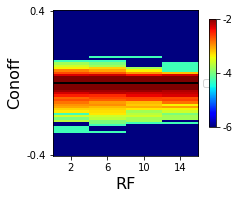

In [16]:
#2d histogram of Conoff and RF for the upper visual field
xmax=14
xmin=2
ymax=0.4
ymin=-0.4
#
temp_onoffs_RF=np.concatenate((upper_UV_RF_onoffs,upper_UV_RF_onoffs),axis=1).flatten()
RFs=np.array([2,6,10,14])#RF, degrees
temp_RFs=np.repeat(RFs,upper_UV_RF_onoffs.shape[1]*2)
temp_onoffs_RF=np.concatenate((temp_onoffs_RF[...,np.newaxis],temp_RFs[...,np.newaxis]),axis=1)
#
weights = np.ones_like(temp_onoffs_RF[:,1])/float(len(temp_onoffs_RF[:,1]))
rfsize_ooidx=np.zeros((4,64))
#
rfsize_ooidx,_,_=np.histogram2d(temp_onoffs_RF[:,1], \
                                temp_onoffs_RF[:,0], \
                                bins=(4,64),range=[[xmin,xmax],[ymin,ymax]],weights=weights)
rfsize_ooidx=np.log10(rfsize_ooidx+1e-6)
rfsize_ooidx=rfsize_ooidx.T
H_max=-2 
H_min=-6 
#
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
im=axes.imshow(rfsize_ooidx, interpolation='nearest', origin='lower',cmap='jet',vmin=H_min, vmax=H_max)
labels = ['2','6','10','14']
axes.set_xticks([0,1,2,3])
axes.set_xticklabels(labels)
labels = [float("{0:.1f}".format(ymin)),float("{0:.1f}".format(ymax))]
axes.set_yticks([0,63])
axes.set_yticklabels(labels)
axes.axhline(y=31.5,color='k',linewidth=2)
axes.set_xlabel('RF', fontsize=16)
axes.set_ylabel('Conoff', fontsize=16)
axes.set_aspect(4/64)
#
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.5])
ticks=[-2,-4,-6]
fig.colorbar(im, cax=cbar_ax,ticks=ticks,format="%d")
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

#### RMS

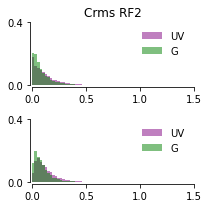

In [17]:
#show Crms RF2 distribution
rms2_upper_UV=np.copy(upper_UV_RF_rms2s[0])
rms2_upper_G =np.copy(upper_G_RF_rms2s[0])
rms2_lower_UV=np.copy(lower_UV_RF_rms2s[0])
rms2_lower_G =np.copy(lower_G_RF_rms2s[0])
rms2_max=1.5 
rms2_min=0 
log_flag=False #log scale histogram if it is True
weights = np.ones_like(rms2_upper_UV)/float(len(rms2_upper_UV))
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(3,3))
axes[0].hist(rms2_upper_UV, bins=64,color='purple',range=[rms2_min,rms2_max],\
               weights=weights,log=log_flag,alpha=0.5,label='UV')
axes[0].hist(rms2_upper_G, bins=64,color='green',range=[rms2_min,rms2_max],\
               weights=weights,log=log_flag,alpha=0.5,label='G')
axes[0].set_xlim([0,1.5])
axes[0].set_xticks([0,0.5,1.0,1.5])
axes[0].set_yticks([0,0.4])
axes[0].set_title('Crms RF2')
axes[0].legend(loc='best',frameon=False)
adjust_spines(axes[0], ['left', 'bottom'])
weights = np.ones_like(rms2_lower_UV)/float(len(rms2_lower_UV))
axes[1].hist(rms2_lower_UV, bins=64,color='purple',range=[rms2_min,rms2_max],\
               weights=weights,log=log_flag,alpha=0.5,label='UV')
axes[1].hist(rms2_lower_G, bins=64,color='green',range=[rms2_min,rms2_max],\
               weights=weights,log=log_flag,alpha=0.5,label='G')
axes[1].set_xlim([0,1.5])
axes[1].set_xticks([0,0.5,1.0,1.5])
axes[1].set_yticks([0,0.4])
axes[1].legend(loc='best',frameon=False)
adjust_spines(axes[1], ['left', 'bottom'])
plt.tight_layout()

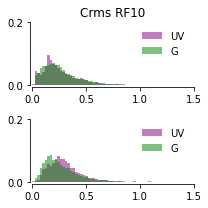

In [18]:
#show Crms RF10 distribution
rms2_upper_UV=np.copy(upper_UV_RF_rms2s[2])
rms2_upper_G =np.copy(upper_G_RF_rms2s[2])
rms2_lower_UV=np.copy(lower_UV_RF_rms2s[2])
rms2_lower_G =np.copy(lower_G_RF_rms2s[2])
rms2_max=1.5 
rms2_min=0 
log_flag=False #log scale histogram if it is True
weights = np.ones_like(rms2_upper_UV)/float(len(rms2_upper_UV))
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(3,3))
axes[0].hist(rms2_upper_UV, bins=64,color='purple',range=[rms2_min,rms2_max],\
               weights=weights,log=log_flag,alpha=0.5,label='UV')
axes[0].hist(rms2_upper_G, bins=64,color='green',range=[rms2_min,rms2_max],\
               weights=weights,log=log_flag,alpha=0.5,label='G')
axes[0].set_xlim([0,1.5])
axes[0].set_xticks([0,0.5,1.0,1.5])
axes[0].set_yticks([0,0.2])
axes[0].set_title('Crms RF10')
axes[0].legend(loc='best',frameon=False)
adjust_spines(axes[0], ['left', 'bottom'])
weights = np.ones_like(rms2_lower_UV)/float(len(rms2_lower_UV))
axes[1].hist(rms2_lower_UV, bins=64,color='purple',range=[rms2_min,rms2_max],\
               weights=weights,log=log_flag,alpha=0.5,label='UV')
axes[1].hist(rms2_lower_G, bins=64,color='green',range=[rms2_min,rms2_max],\
               weights=weights,log=log_flag,alpha=0.5,label='G')
axes[1].set_xlim([0,1.5])
axes[1].set_xticks([0,0.5,1.0,1.5])
axes[1].set_yticks([0,0.2])
axes[1].legend(loc='best',frameon=False)
adjust_spines(axes[1], ['left', 'bottom'])
plt.tight_layout()

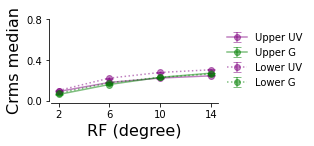

In [19]:
#calculate rms2medians
RFradius=np.array([2,7,12,16])
#upper visual field, UV channel
upper_UV_RF_rms2medians=np.zeros(4)
upper_UV_RF_rms2stds=np.zeros(4)
upper_UV_RF_rms2lowqs=np.zeros(4) #lower_quartile
upper_UV_RF_rms2higqs=np.zeros(4) #upper_quartile
for ii in range(4):
    upper_UV_RF_rms2medians[ii]=np.median(upper_UV_RF_rms2s[ii])
    low_perc,high_perc=bootstrap('median',upper_UV_RF_rms2s[ii],num_exp=10000,seed=66)
    upper_UV_RF_rms2lowqs[ii]  = upper_UV_RF_rms2medians[ii]-low_perc
    upper_UV_RF_rms2higqs[ii]  =-upper_UV_RF_rms2medians[ii]+high_perc
#upper visual field, G channel
upper_G_RF_rms2medians=np.zeros(4)
upper_G_RF_rms2stds=np.zeros(4)
upper_G_RF_rms2lowqs=np.zeros(4) #lower_quartile
upper_G_RF_rms2higqs=np.zeros(4) #upper_quartile
for ii in range(4):
    upper_G_RF_rms2medians[ii]=np.median(upper_G_RF_rms2s[ii])
    low_perc,high_perc=bootstrap('median',upper_G_RF_rms2s[ii],num_exp=10000,seed=66)
    upper_G_RF_rms2lowqs[ii]  = upper_G_RF_rms2medians[ii]-low_perc
    upper_G_RF_rms2higqs[ii]  =-upper_G_RF_rms2medians[ii]+high_perc
#lower visual field, UV channel
lower_UV_RF_rms2medians=np.zeros(4)
lower_UV_RF_rms2stds=np.zeros(4)
lower_UV_RF_rms2lowqs=np.zeros(4) #lower_quartile
lower_UV_RF_rms2higqs=np.zeros(4) #upper_quartile
for ii in range(4):
    lower_UV_RF_rms2medians[ii]=np.median(lower_UV_RF_rms2s[ii])
    low_perc,high_perc=bootstrap('median',lower_UV_RF_rms2s[ii],num_exp=10000,seed=88)
    lower_UV_RF_rms2lowqs[ii]  = lower_UV_RF_rms2medians[ii]-low_perc
    lower_UV_RF_rms2higqs[ii]  =-lower_UV_RF_rms2medians[ii]+high_perc
#lower visual field, G channel
lower_G_RF_rms2medians=np.zeros(4)
lower_G_RF_rms2stds=np.zeros(4)
lower_G_RF_rms2lowqs=np.zeros(4) #lower_quartile
lower_G_RF_rms2higqs=np.zeros(4) #upper_quartile
for ii in range(4):
    lower_G_RF_rms2medians[ii]=np.median(lower_G_RF_rms2s[ii])
    low_perc,high_perc=bootstrap('median',lower_G_RF_rms2s[ii],num_exp=10000,seed=88)
    lower_G_RF_rms2lowqs[ii]  = lower_G_RF_rms2medians[ii]-low_perc
    lower_G_RF_rms2higqs[ii]  =-lower_G_RF_rms2medians[ii]+high_perc
#plot
RFs=np.array([2,6,10,14])
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,1.5))
ax.errorbar(RFs,upper_UV_RF_rms2medians,yerr=(upper_UV_RF_rms2lowqs,upper_UV_RF_rms2higqs),marker='o',\
            color='purple',linestyle='-', label='Upper UV',alpha=0.5, capsize=4)
ax.errorbar(RFs,upper_G_RF_rms2medians, yerr=(upper_G_RF_rms2lowqs, upper_G_RF_rms2higqs), marker='o',\
            color='g',linestyle='-', label='Upper G',alpha=0.5, capsize=4)
ax.errorbar(RFs,lower_UV_RF_rms2medians,yerr=(lower_UV_RF_rms2lowqs,lower_UV_RF_rms2higqs),marker='o',\
            color='purple',linestyle=':', label='Lower UV',alpha=0.5, capsize=4)
ax.errorbar(RFs,lower_G_RF_rms2medians, yerr=(lower_G_RF_rms2lowqs, lower_G_RF_rms2higqs), marker='o',\
            color='g',linestyle=':', label='Lower G',alpha=0.5, capsize=4)
ax.legend(loc='best',fontsize=16)
ax.set_xticks([2,6,10,14])
ax.set_yticks([0,0.4,0.8])
ax.set_xlabel('RF (degree)', fontsize=16)
ax.set_ylabel('Crms median', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))

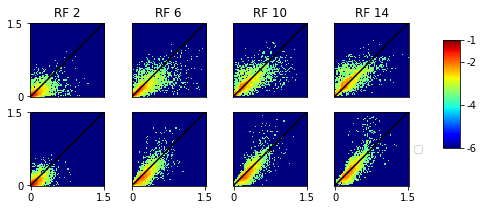

In [20]:
#Crms relationship in two color channels, 2d histogram
xmax=1.5 
xmin=0 
ymax=1.5 
ymin=0 
RFradius=np.array(['RF 2','RF 6','RF 10','RF 14'])
H_upper_RF_rms2s=np.zeros((4,64,64))
H_lower_RF_rms2s=np.zeros((4,64,64))
for ii in range(4):
    weights = np.ones_like(upper_UV_RF_rms2s[0])/float(len(upper_UV_RF_rms2s[0]))
    H_upper_RF_rms2s[ii],_,_=np.histogram2d(upper_UV_RF_rms2s[ii], \
                                   upper_G_RF_rms2s[ii], \
                                   bins=64,range=[[xmin,xmax],[ymin,ymax]],weights=weights)
    H_upper_RF_rms2s[ii]=np.log10(H_upper_RF_rms2s[ii]+1e-6)
    H_upper_RF_rms2s[ii]=H_upper_RF_rms2s[ii].T
    weights = np.ones_like(lower_UV_RF_rms2s[0])/float(len(lower_UV_RF_rms2s[0]))
    H_lower_RF_rms2s[ii],_,_=np.histogram2d(lower_UV_RF_rms2s[ii], \
                                   lower_G_RF_rms2s[ii], \
                                   bins=64,range=[[xmin,xmax],[ymin,ymax]],weights=weights)
    H_lower_RF_rms2s[ii]=np.log10(H_lower_RF_rms2s[ii]+1e-6)
    H_lower_RF_rms2s[ii]=H_lower_RF_rms2s[ii].T
#plot
H_max=-1 
H_min=-6 
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(8,3))
for ii in range(4):
    axes[0,ii].imshow(H_upper_RF_rms2s[ii], interpolation='nearest', origin='lower',cmap='jet',vmin=H_min, vmax=H_max)
    axes[0,ii].set_title(RFradius[ii])
    axes[0,ii].set_xticks([])
    axes[0,ii].set_yticks([])
    if ii==0:
        labels = [str(ymin),float("{0:.1f}".format(ymax))]
        axes[0,ii].set_yticks([0,63])
        axes[0,ii].set_yticklabels(labels)
    lims = [np.min([axes[0,ii].get_xlim(), axes[0,ii].get_ylim()]),  # min of both axes
            np.max([axes[0,ii].get_xlim(), axes[0,ii].get_ylim()]),  # max of both axes
           ]
    axes[0,ii].plot(lims, lims, 'k-')  
for ii in range(4):
    im=axes[1,ii].imshow(H_lower_RF_rms2s[ii], interpolation='nearest', origin='lower',cmap='jet',vmin=H_min, vmax=H_max)
    axes[1,ii].set_yticks([])
    labels = [str(xmin),float("{0:.1f}".format(xmax))]
    axes[1,ii].set_xticks([0,63])
    axes[1,ii].set_xticklabels(labels)
    if ii==0:
        labels = [str(ymin),float("{0:.1f}".format(ymax))]
        axes[1,ii].set_yticks([0,63])
        axes[1,ii].set_yticklabels(labels)
    lims = [np.min([axes[1,ii].get_xlim(), axes[1,ii].get_ylim()]),  # min of both axes
            np.max([axes[1,ii].get_xlim(), axes[1,ii].get_ylim()]),  # max of both axes
           ]
    axes[1,ii].plot(lims, lims, 'k-')      
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.5])
ticks=[-1,-2,-4,-6]
fig.colorbar(im, cax=cbar_ax,ticks=ticks,format="%d")
handles, labels = axes[1,3].get_legend_handles_labels()
lgd = axes[1,3].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

#### JSD

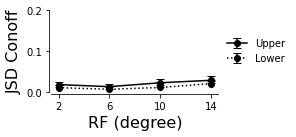

In [21]:
#onoff
upper_RF_JSD_onoffs=np.zeros(4)
upper_RF_JSD_onoff_stds=np.zeros(4)
upper_RF_JSD_onoff_lowqs=np.zeros(4) 
upper_RF_JSD_onoff_higqs=np.zeros(4) 
for ii in range(4):
    upper_RF_JSD_onoffs[ii]    =JSD(upper_UV_RF_onoffs[ii], upper_G_RF_onoffs[ii], 64)
    low_perc,high_perc=bootstrap_JSD((upper_UV_RF_onoffs[ii], upper_G_RF_onoffs[ii]),num_exp=10000,seed=66,bins=64)
    upper_RF_JSD_onoff_lowqs[ii]  = upper_RF_JSD_onoffs[ii]-low_perc
    upper_RF_JSD_onoff_higqs[ii]  =-upper_RF_JSD_onoffs[ii]+high_perc
#
lower_RF_JSD_onoffs=np.zeros(4)
lower_RF_JSD_onoff_stds=np.zeros(4)
lower_RF_JSD_onoff_lowqs=np.zeros(4) #lower_quartile
lower_RF_JSD_onoff_higqs=np.zeros(4) #upper_quartile
for ii in range(4):
    lower_RF_JSD_onoffs[ii]    =JSD(lower_UV_RF_onoffs[ii], lower_G_RF_onoffs[ii], 64)
    low_perc,high_perc=bootstrap_JSD((lower_UV_RF_onoffs[ii], lower_G_RF_onoffs[ii]),num_exp=10000,seed=66,bins=64)
    lower_RF_JSD_onoff_lowqs[ii]  = lower_RF_JSD_onoffs[ii]-low_perc
    lower_RF_JSD_onoff_higqs[ii]  =-lower_RF_JSD_onoffs[ii]+high_perc
#plot
RFs=np.array([2,6,10,14])#RF, degrees
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,1.5))
ax.errorbar(RFs,upper_RF_JSD_onoffs,yerr=(upper_RF_JSD_onoff_lowqs,upper_RF_JSD_onoff_higqs),marker='o',\
            color='k',linestyle='-', label='Upper',alpha=1, capsize=4)
ax.errorbar(RFs,lower_RF_JSD_onoffs,yerr=(lower_RF_JSD_onoff_lowqs,lower_RF_JSD_onoff_higqs),marker='o',\
            color='k',linestyle=':', label='Lower',alpha=1, capsize=4)
ax.legend(loc='best',fontsize=16)
ax.set_xticks([2,6,10,14])
ax.set_yticks([0,0.1,0.2])
ax.set_xlabel('RF (degree)', fontsize=16)
ax.set_ylabel('JSD Conoff', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left', frameon=False,bbox_to_anchor=(1, 0.5))

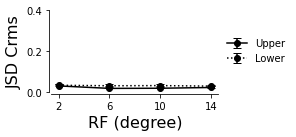

In [22]:
#rms2
upper_RF_JSD_rms2s=np.zeros(4)
upper_RF_JSD_rms2_stds=np.zeros(4)
upper_RF_JSD_rms2_lowqs=np.zeros(4) #lower_quartile
upper_RF_JSD_rms2_higqs=np.zeros(4) #upper_quartile
for ii in range(4):
    upper_RF_JSD_rms2s[ii]    =JSD(upper_UV_RF_rms2s[ii], upper_G_RF_rms2s[ii], 64)
    low_perc,high_perc=bootstrap_JSD((upper_UV_RF_rms2s[ii], upper_G_RF_rms2s[ii]),num_exp=10000,seed=66,bins=64)
    upper_RF_JSD_rms2_lowqs[ii]  = upper_RF_JSD_rms2s[ii]-low_perc
    upper_RF_JSD_rms2_higqs[ii]  =-upper_RF_JSD_rms2s[ii]+high_perc
#
lower_RF_JSD_rms2s=np.zeros(4)
lower_RF_JSD_rms2_stds=np.zeros(4)
lower_RF_JSD_rms2_lowqs=np.zeros(4) #lower_quartile
lower_RF_JSD_rms2_higqs=np.zeros(4) #upper_quartile
for ii in range(4):
    lower_RF_JSD_rms2s[ii]=JSD(lower_UV_RF_rms2s[ii], lower_G_RF_rms2s[ii], 64)
    low_perc,high_perc=bootstrap_JSD((lower_UV_RF_rms2s[ii], lower_G_RF_rms2s[ii]),num_exp=10000,seed=66,bins=64)
    lower_RF_JSD_rms2_lowqs[ii]  = lower_RF_JSD_rms2s[ii]-low_perc
    lower_RF_JSD_rms2_higqs[ii]  =-lower_RF_JSD_rms2s[ii]+high_perc
#plot
RFs=np.array([2,6,10,14])
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,1.5))
ax.errorbar(RFs,upper_RF_JSD_rms2s,yerr=(upper_RF_JSD_rms2_lowqs,upper_RF_JSD_rms2_higqs),marker='o',\
            color='k',linestyle='-', label='Upper',alpha=1, capsize=4)
ax.errorbar(RFs,lower_RF_JSD_rms2s,yerr=(lower_RF_JSD_rms2_lowqs,lower_RF_JSD_rms2_higqs),marker='o',\
            color='k',linestyle=':', label='Lower',alpha=1, capsize=4)
ax.legend(loc='best',fontsize=16)
ax.set_xticks([2,6,10,14])
ax.set_yticks([0.0,0.2,0.4])
ax.set_xlabel('RF (degree)', fontsize=16)
ax.set_ylabel('JSD Crms', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))

#### permutation test

In [23]:
#rms, along color and visual fields
#RF=2
temp=[upper_UV_RF_rms2s[0], upper_G_RF_rms2s[0], lower_UV_RF_rms2s[0], lower_G_RF_rms2s[0]]
print (perm_test_group(temp,nmc=10000,randomseed=66))
#RF=6
temp=[upper_UV_RF_rms2s[1], upper_G_RF_rms2s[1], lower_UV_RF_rms2s[1], lower_G_RF_rms2s[1]]
print (perm_test_group(temp,nmc=10000,randomseed=66))
#RF=10
temp=[upper_UV_RF_rms2s[2], upper_G_RF_rms2s[2], lower_UV_RF_rms2s[2], lower_G_RF_rms2s[2]]
print (perm_test_group(temp,nmc=10000,randomseed=66))
#RF=14
temp=[upper_UV_RF_rms2s[3], upper_G_RF_rms2s[3], lower_UV_RF_rms2s[3], lower_G_RF_rms2s[3]]
print (perm_test_group(temp,nmc=10000,randomseed=66))

[0.0, 0.0001, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.3896, 0.0, 0.0, 0.0]
[0.0521, 0.0, 0.0631, 0.0, 0.8926, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0768, 0.0]


In [24]:
#rms, along RFs
#upper_UV
temp=[upper_UV_RF_rms2s[0], upper_UV_RF_rms2s[1], upper_UV_RF_rms2s[2], upper_UV_RF_rms2s[3]]
print (perm_test_group(temp,nmc=10000,randomseed=66))
#upper_G
temp=[upper_G_RF_rms2s[0],  upper_G_RF_rms2s[1],  upper_G_RF_rms2s[2],  upper_G_RF_rms2s[3] ]
print (perm_test_group(temp,nmc=10000,randomseed=66))
#lower_UV
temp=[lower_UV_RF_rms2s[0], lower_UV_RF_rms2s[1], lower_UV_RF_rms2s[2], lower_UV_RF_rms2s[3]]
print (perm_test_group(temp,nmc=10000,randomseed=66))
#lower_G
temp=[lower_G_RF_rms2s[0],  lower_G_RF_rms2s[1],  lower_G_RF_rms2s[2],  lower_G_RF_rms2s[3] ]
print (perm_test_group(temp,nmc=10000,randomseed=66))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [25]:
#onoff, along color and visual fields
#RF=2
temp=[upper_UV_RF_onoffs[0], upper_G_RF_onoffs[0], lower_UV_RF_onoffs[0], lower_G_RF_onoffs[0]]
print (perm_test_group(temp,nmc=10000,randomseed=66))
#RF=6
temp=[upper_UV_RF_onoffs[1], upper_G_RF_onoffs[1], lower_UV_RF_onoffs[1], lower_G_RF_onoffs[1]]
print (perm_test_group(temp,nmc=10000,randomseed=66))
#RF=10
temp=[upper_UV_RF_onoffs[2], upper_G_RF_onoffs[2], lower_UV_RF_onoffs[2], lower_G_RF_onoffs[2]]
print (perm_test_group(temp,nmc=10000,randomseed=66))
#RF=14
temp=[upper_UV_RF_onoffs[3], upper_G_RF_onoffs[3], lower_UV_RF_onoffs[3], lower_G_RF_onoffs[3]]
print (perm_test_group(temp,nmc=10000,randomseed=66))

[0.001, 0.0, 0.0006, 0.0, 0.4675, 0.0014]
[0.0, 0.0, 0.0, 0.0116, 0.585, 0.0865]
[0.0, 0.0001, 0.5744, 0.0001, 0.0, 0.013]
[0.0, 0.0, 0.1236, 0.0, 0.0, 0.0]


In [26]:
#onoff, along RFs
#upper_UV
temp=[upper_UV_RF_onoffs[0], upper_UV_RF_onoffs[1], upper_UV_RF_onoffs[2], upper_UV_RF_onoffs[3]]
print (perm_test_group(temp,nmc=10000,randomseed=66))
#upper_G
temp=[upper_G_RF_onoffs[0],  upper_G_RF_onoffs[1],  upper_G_RF_onoffs[2],  upper_G_RF_onoffs[3] ]
print (perm_test_group(temp,nmc=10000,randomseed=66))
#lower_UV
temp=[lower_UV_RF_onoffs[0], lower_UV_RF_onoffs[1], lower_UV_RF_onoffs[2], lower_UV_RF_onoffs[3]]
print (perm_test_group(temp,nmc=10000,randomseed=66))
#lower_G
temp=[lower_G_RF_onoffs[0],  lower_G_RF_onoffs[1],  lower_G_RF_onoffs[2],  lower_G_RF_onoffs[3] ]
print (perm_test_group(temp,nmc=10000,randomseed=66))

[0.0, 0.0001, 0.5502, 0.0294, 0.0001, 0.1266]
[0.0093, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.8311, 0.0262, 0.0018, 0.0159, 0.0134, 0.0]
[0.1939, 0.0022, 0.0, 0.0006, 0.0, 0.5453]
